#### MTA Project mvp
###### Project Goal
- Generate data to facilitate micro-targeted advertising based on time of day and demographics.
- I am focusing on the Canal St. station with one month of data, but the methodology and 
code can be easily be applied to other stations and time frames.
    
###### Milestone Reached
- Designed and implemented methodology to reliably structure data to access traffic data by time intervals as small as four hours, by line name and station entrance.
- While this is not direct demographic information, the line routes and time of day in combination, have the potential for demographic targeting
- The data resulting from this analysis and processing for the Canal St. station for one month is the last cell in this notebook.


###### Key Tasks Completed
- Examined and purged data resulting from turnstile audits and resets
- Identified, analyzed and purged data with negative net entires or exits
- Identified, analyzed and as appropriate purged data with anomalously large entries/exits. Chose 1,500 
 per time interval per unique turnstile identifier as the cut-off
- Identified, analyzed and purged data with 0 entries/exits. This data indicated a station/line closure on certain days
- Analyzed data to confirm consistency of time intervals used by the system within each turnstile unit and line name
- Performed analysis to confirm that each unique combination of turnstile identifyers CA, UNIT,
and SCP are associated with a single line name. Looking at a map of NYC subway routes, line names claerly match specific entrances. Refer to next to last cell
- Please refer to comments on notebook cells for more detail on specific tasks and process



In [236]:
reset -fs

In [237]:
import pandas as pd
import sqlalchemy as alchem
from sqlalchemy import inspect
from sqlalchemy import create_engine 
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

In [238]:
engine = create_engine("sqlite:///sep_21.db")
engine.connect()

In [239]:
"""
In the next few cells, I just experiment with sqlalchemy and syntax. Here I'm creating a variable
to define my column selections use it as part of string literal in a query
"""

columns_to_select = ['CA', 'UNIT', 'SCP', 'STATION', 'DATE', 'TIME', 'DESC', 'ENTRIES', 'EXITS']
my_select = 'SELECT '

for name in columns_to_select:
    my_select = my_select + name +', '
my_select = my_select[:-2]
my_select

'SELECT CA, UNIT, SCP, STATION, DATE, TIME, DESC, ENTRIES, EXITS'

In [240]:

"""
Just a test a test to put a query in a dataframe
"""

test_df = pd.read_sql(f'{my_select}\
                      FROM  mta_data WHERE STATION = "CANAL ST";', 
                       engine)
test_df.sort_values("DATE").tail()

,CA,UNIT,SCP,STATION,DATE,TIME,DESC,ENTRIES,EXITS
246,A043,R462,00-03-02,CANAL ST,10/29/2021,01:00:00,REGULAR,4380269,1958117
247,A043,R462,00-03-02,CANAL ST,10/29/2021,05:00:00,REGULAR,4380271,1958117
248,A043,R462,00-03-02,CANAL ST,10/29/2021,09:00:00,REGULAR,4380279,1958139
1925,N090,R139,01-00-00,CANAL ST,10/29/2021,20:00:00,REGULAR,1394413,14260792
1420,N089,R139,00-00-00,CANAL ST,10/29/2021,12:00:00,REGULAR,6396101,17664116


In [180]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12170 entries, 0 to 12169
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   CA       12170 non-null  object
 1   UNIT     12170 non-null  object
 2   SCP      12170 non-null  object
 3   STATION  12170 non-null  object
 4   DATE     12170 non-null  object
 5   TIME     12170 non-null  object
 6   DESC     12170 non-null  object
 7   ENTRIES  12170 non-null  int64 
 8   EXITS    12170 non-null  int64 
dtypes: int64(2), object(7)
memory usage: 855.8+ KB


In [242]:
test_df.columns

Index(['CA', 'UNIT', 'SCP', 'STATION', 'DATE', 'TIME', 'DESC', 'ENTRIES',
       'EXITS'],
      dtype='object')

In [241]:
"""
Looking at recovery audits with a sqlalchemy query
"""

pd.read_sql('SELECT *\
                      FROM  mta_data WHERE STATION = "CANAL ST" \
                      AND NOT DESC  =  "REGULAR" \
                      ;', \
                       engine)

,CA,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A046,R463,00-05-02,CANAL ST,JNQRZ6W,BMT,10/29/2021,13:00:00,RECOVR AUD,2,0
1,A066,R118,00-00-00,CANAL ST,JNQRZ6W,BMT,10/28/2021,13:00:00,RECOVR AUD,1722475571,1763975567
2,A066,R118,00-00-00,CANAL ST,JNQRZ6W,BMT,10/28/2021,17:00:00,RECOVR AUD,1722475093,1763975867
3,A066,R118,00-00-00,CANAL ST,JNQRZ6W,BMT,10/28/2021,21:00:00,RECOVR AUD,1722474514,1763976238
4,A066,R118,00-00-00,CANAL ST,JNQRZ6W,BMT,10/29/2021,01:00:00,RECOVR AUD,1722474382,1763976328
5,A066,R118,00-00-01,CANAL ST,JNQRZ6W,BMT,10/28/2021,13:00:00,RECOVR AUD,11254674,3845956
6,A066,R118,00-00-01,CANAL ST,JNQRZ6W,BMT,10/28/2021,17:00:00,RECOVR AUD,11255201,3846141
7,A066,R118,00-00-01,CANAL ST,JNQRZ6W,BMT,10/28/2021,21:00:00,RECOVR AUD,11255825,3846337
8,A066,R118,00-00-01,CANAL ST,JNQRZ6W,BMT,10/29/2021,01:00:00,RECOVR AUD,11255960,3846400
9,A066,R118,00-00-02,CANAL ST,JNQRZ6W,BMT,10/28/2021,13:00:00,RECOVR AUD,340538375,2031566895


In [183]:

"""
Examining data around audit anomalies with sqlalchemey query

"""

pd.read_sql('SELECT *\
                      FROM  mta_data \
                      WHERE STATION = "CANAL ST" \
                      AND TIME = "21:00:00" \
                      AND DATE = "10/28/2021"\
                      ;', \
                       engine)

,CA,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A043,R462,00-00-00,CANAL ST,JNQRZ6W,BMT,10/28/2021,21:00:00,REGULAR,371827470,456792118
1,A043,R462,00-00-01,CANAL ST,JNQRZ6W,BMT,10/28/2021,21:00:00,REGULAR,355855007,441410820
2,A043,R462,00-00-02,CANAL ST,JNQRZ6W,BMT,10/28/2021,21:00:00,REGULAR,14665079,14138082
3,A043,R462,00-03-00,CANAL ST,JNQRZ6W,BMT,10/28/2021,21:00:00,REGULAR,5766024,4119672
4,A043,R462,00-03-01,CANAL ST,JNQRZ6W,BMT,10/28/2021,21:00:00,REGULAR,5369619,1842413
5,A043,R462,00-03-02,CANAL ST,JNQRZ6W,BMT,10/28/2021,21:00:00,REGULAR,4380238,1958114
6,A043,R462,00-03-03,CANAL ST,JNQRZ6W,BMT,10/28/2021,21:00:00,REGULAR,54812,59104
7,A043,R462,00-03-04,CANAL ST,JNQRZ6W,BMT,10/28/2021,21:00:00,REGULAR,8987888,9033667
8,A043,R462,00-06-00,CANAL ST,JNQRZ6W,BMT,10/28/2021,21:00:00,REGULAR,1247273,481144
9,A043,R462,00-06-01,CANAL ST,JNQRZ6W,BMT,10/28/2021,21:00:00,REGULAR,4282387,1956919


In [184]:
pd.read_sql('SELECT *\
                      FROM  mta_data WHERE STATION = "CANAL ST" \
                      AND TIME = "20:00:00" \
                      AND DATE = "09/25/2021"\
                      ;', \
                       engine)

,CA,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,N089,R139,00-00-00,CANAL ST,ACE,IND,09/25/2021,20:00:00,RECOVR AUD,6387710,17611435
1,N089,R139,00-00-01,CANAL ST,ACE,IND,09/25/2021,20:00:00,RECOVR AUD,518753,746084
2,N089,R139,00-00-02,CANAL ST,ACE,IND,09/25/2021,20:00:00,RECOVR AUD,1768576,1348598
3,N089,R139,00-03-00,CANAL ST,ACE,IND,09/25/2021,20:00:00,RECOVR AUD,515718,392336
4,N089,R139,00-03-01,CANAL ST,ACE,IND,09/25/2021,20:00:00,RECOVR AUD,1200363,636369
5,N089,R139,00-03-02,CANAL ST,ACE,IND,09/25/2021,20:00:00,RECOVR AUD,1899495,869286
6,N089,R139,00-04-00,CANAL ST,ACE,IND,09/25/2021,20:00:00,RECOVR AUD,926579784,553960733
7,N089,R139,00-04-01,CANAL ST,ACE,IND,09/25/2021,20:00:00,RECOVR AUD,2093209,537804
8,N089,R139,00-04-02,CANAL ST,ACE,IND,09/25/2021,20:00:00,RECOVR AUD,3042412,1598087
9,N089,R139,00-06-00,CANAL ST,ACE,IND,09/25/2021,20:00:00,RECOVR AUD,21334,294444


In [185]:
pd.read_sql('SELECT *\
                      FROM  mta_data \
                      WHERE STATION = "CANAL ST" AND DESC = "REGULAR" \
                      GROUP BY CA,UNIT,SCP;', \
                      engine)

,CA,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A043,R462,00-00-00,CANAL ST,JNQRZ6W,BMT,10/23/2021,01:00:00,REGULAR,371824281,456786135
1,A043,R462,00-00-01,CANAL ST,JNQRZ6W,BMT,10/23/2021,01:00:00,REGULAR,355851923,441403275
2,A043,R462,00-00-02,CANAL ST,JNQRZ6W,BMT,10/23/2021,01:00:00,REGULAR,14660242,14130449
3,A043,R462,00-03-00,CANAL ST,JNQRZ6W,BMT,10/23/2021,01:00:00,REGULAR,5763206,4117293
4,A043,R462,00-03-01,CANAL ST,JNQRZ6W,BMT,10/23/2021,01:00:00,REGULAR,5367817,1841555
5,A043,R462,00-03-02,CANAL ST,JNQRZ6W,BMT,10/23/2021,01:00:00,REGULAR,4378883,1957099
6,A043,R462,00-03-03,CANAL ST,JNQRZ6W,BMT,10/23/2021,01:00:00,REGULAR,53506,57658
7,A043,R462,00-03-04,CANAL ST,JNQRZ6W,BMT,10/23/2021,01:00:00,REGULAR,8985816,9030155
8,A043,R462,00-06-00,CANAL ST,JNQRZ6W,BMT,10/23/2021,01:00:00,REGULAR,1243036,477343
9,A043,R462,00-06-01,CANAL ST,JNQRZ6W,BMT,10/23/2021,01:00:00,REGULAR,4279155,1955140


In [186]:
pd.read_sql('SELECT *, COUNT(ENTRIES)\
            FROM  mta_data \
            WHERE STATION = "CANAL ST" AND DESC = "REGULAR" \
            GROUP BY LINENAME, DATE, TIME \
            ORDER BY LINENAME;', engine).drop('DIVISION', axis = 1)

,CA,UNIT,SCP,STATION,LINENAME,DATE,TIME,DESC,ENTRIES,EXITS,COUNT(ENTRIES)
0,R119,R320,00-00-00,CANAL ST,1,09/25/2021,01:00:00,REGULAR,1912268,791471,6
1,R119,R320,00-00-00,CANAL ST,1,09/25/2021,05:00:00,REGULAR,1912283,791473,6
2,R119,R320,00-00-00,CANAL ST,1,09/25/2021,09:00:00,REGULAR,1912291,791478,6
3,R119,R320,00-00-00,CANAL ST,1,09/25/2021,13:00:00,REGULAR,1912322,791502,6
4,R119,R320,00-00-00,CANAL ST,1,09/25/2021,17:00:00,REGULAR,1912424,791556,6
...,...,...,...,...,...,...,...,...,...,...,...
624,A043,R462,00-00-00,CANAL ST,JNQRZ6W,10/29/2021,05:00:00,REGULAR,371827530,456792152,33
625,A043,R462,00-00-00,CANAL ST,JNQRZ6W,10/29/2021,09:00:00,REGULAR,371827538,456792341,32
626,A043,R462,00-00-00,CANAL ST,JNQRZ6W,10/29/2021,13:00:00,REGULAR,371827587,456792674,31
627,A043,R462,00-00-00,CANAL ST,JNQRZ6W,10/29/2021,17:00:00,REGULAR,371827772,456792974,33


In [243]:
"""
At this point I have conducted some exploration and analyis with sqlalchemey queries. I pull data
into a dataframe, excluding any rows where DESC is not "REGULAR". This exlcudes all rows with 
audit resets.
"""

df = pd.read_sql('SELECT *\
            FROM  mta_data \
            WHERE STATION = "CANAL ST" AND DESC = "REGULAR" '\
            , engine).drop('DIVISION', axis = 1)
df

,CA,UNIT,SCP,STATION,LINENAME,DATE,TIME,DESC,ENTRIES,EXITS
0,A043,R462,00-00-00,CANAL ST,JNQRZ6W,10/23/2021,01:00:00,REGULAR,371824281,456786135
1,A043,R462,00-00-00,CANAL ST,JNQRZ6W,10/23/2021,05:00:00,REGULAR,371824284,456786141
2,A043,R462,00-00-00,CANAL ST,JNQRZ6W,10/23/2021,09:00:00,REGULAR,371824286,456786210
3,A043,R462,00-00-00,CANAL ST,JNQRZ6W,10/23/2021,13:00:00,REGULAR,371824313,456786548
4,A043,R462,00-00-00,CANAL ST,JNQRZ6W,10/23/2021,17:00:00,REGULAR,371824495,456786992
...,...,...,...,...,...,...,...,...,...,...
12130,R120,R320,01-00-02,CANAL ST,1,10/01/2021,05:00:00,REGULAR,1483244,8378167
12131,R120,R320,01-00-02,CANAL ST,1,10/01/2021,09:00:00,REGULAR,1483247,8378314
12132,R120,R320,01-00-02,CANAL ST,1,10/01/2021,13:00:00,REGULAR,1483256,8378434
12133,R120,R320,01-00-02,CANAL ST,1,10/01/2021,17:00:00,REGULAR,1483277,8378556


In [244]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12135 entries, 0 to 12134
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   CA        12135 non-null  object
 1   UNIT      12135 non-null  object
 2   SCP       12135 non-null  object
 3   STATION   12135 non-null  object
 4   LINENAME  12135 non-null  object
 5   DATE      12135 non-null  object
 6   TIME      12135 non-null  object
 7   DESC      12135 non-null  object
 8   ENTRIES   12135 non-null  int64 
 9   EXITS     12135 non-null  int64 
dtypes: int64(2), object(8)
memory usage: 948.2+ KB


In [245]:
"""
Create columns for previous entires and exits with Shift 
"""

df[['prev_ent', 'prev_ex']] = df[['ENTRIES', 'EXITS']].shift(1)
df

,CA,UNIT,SCP,STATION,LINENAME,DATE,TIME,DESC,ENTRIES,EXITS,prev_ent,prev_ex
0,A043,R462,00-00-00,CANAL ST,JNQRZ6W,10/23/2021,01:00:00,REGULAR,371824281,456786135,NaN,NaN
1,A043,R462,00-00-00,CANAL ST,JNQRZ6W,10/23/2021,05:00:00,REGULAR,371824284,456786141,371824281.0,456786135.0
2,A043,R462,00-00-00,CANAL ST,JNQRZ6W,10/23/2021,09:00:00,REGULAR,371824286,456786210,371824284.0,456786141.0
3,A043,R462,00-00-00,CANAL ST,JNQRZ6W,10/23/2021,13:00:00,REGULAR,371824313,456786548,371824286.0,456786210.0
4,A043,R462,00-00-00,CANAL ST,JNQRZ6W,10/23/2021,17:00:00,REGULAR,371824495,456786992,371824313.0,456786548.0
...,...,...,...,...,...,...,...,...,...,...,...,...
12130,R120,R320,01-00-02,CANAL ST,1,10/01/2021,05:00:00,REGULAR,1483244,8378167,1483243.0,8378162.0
12131,R120,R320,01-00-02,CANAL ST,1,10/01/2021,09:00:00,REGULAR,1483247,8378314,1483244.0,8378167.0
12132,R120,R320,01-00-02,CANAL ST,1,10/01/2021,13:00:00,REGULAR,1483256,8378434,1483247.0,8378314.0
12133,R120,R320,01-00-02,CANAL ST,1,10/01/2021,17:00:00,REGULAR,1483277,8378556,1483256.0,8378434.0


In [246]:

"""
Calculate columns for net entries and exists for each time interval and turnstile unit
"""

df['net_ent'] = df.ENTRIES - df.prev_ent 
df['net_ex'] = df.EXITS - df.prev_ex
df

,CA,UNIT,SCP,STATION,LINENAME,DATE,TIME,DESC,ENTRIES,EXITS,prev_ent,prev_ex,net_ent,net_ex
0,A043,R462,00-00-00,CANAL ST,JNQRZ6W,10/23/2021,01:00:00,REGULAR,371824281,456786135,NaN,NaN,NaN,NaN
1,A043,R462,00-00-00,CANAL ST,JNQRZ6W,10/23/2021,05:00:00,REGULAR,371824284,456786141,371824281.0,456786135.0,3.0,6.0
2,A043,R462,00-00-00,CANAL ST,JNQRZ6W,10/23/2021,09:00:00,REGULAR,371824286,456786210,371824284.0,456786141.0,2.0,69.0
3,A043,R462,00-00-00,CANAL ST,JNQRZ6W,10/23/2021,13:00:00,REGULAR,371824313,456786548,371824286.0,456786210.0,27.0,338.0
4,A043,R462,00-00-00,CANAL ST,JNQRZ6W,10/23/2021,17:00:00,REGULAR,371824495,456786992,371824313.0,456786548.0,182.0,444.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12130,R120,R320,01-00-02,CANAL ST,1,10/01/2021,05:00:00,REGULAR,1483244,8378167,1483243.0,8378162.0,1.0,5.0
12131,R120,R320,01-00-02,CANAL ST,1,10/01/2021,09:00:00,REGULAR,1483247,8378314,1483244.0,8378167.0,3.0,147.0
12132,R120,R320,01-00-02,CANAL ST,1,10/01/2021,13:00:00,REGULAR,1483256,8378434,1483247.0,8378314.0,9.0,120.0
12133,R120,R320,01-00-02,CANAL ST,1,10/01/2021,17:00:00,REGULAR,1483277,8378556,1483256.0,8378434.0,21.0,122.0


In [247]:
"""
Drop first row with Nan
"""
df.drop(0, inplace = True)
df

,CA,UNIT,SCP,STATION,LINENAME,DATE,TIME,DESC,ENTRIES,EXITS,prev_ent,prev_ex,net_ent,net_ex
1,A043,R462,00-00-00,CANAL ST,JNQRZ6W,10/23/2021,05:00:00,REGULAR,371824284,456786141,371824281.0,456786135.0,3.0,6.0
2,A043,R462,00-00-00,CANAL ST,JNQRZ6W,10/23/2021,09:00:00,REGULAR,371824286,456786210,371824284.0,456786141.0,2.0,69.0
3,A043,R462,00-00-00,CANAL ST,JNQRZ6W,10/23/2021,13:00:00,REGULAR,371824313,456786548,371824286.0,456786210.0,27.0,338.0
4,A043,R462,00-00-00,CANAL ST,JNQRZ6W,10/23/2021,17:00:00,REGULAR,371824495,456786992,371824313.0,456786548.0,182.0,444.0
5,A043,R462,00-00-00,CANAL ST,JNQRZ6W,10/23/2021,21:00:00,REGULAR,371824729,456787245,371824495.0,456786992.0,234.0,253.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12130,R120,R320,01-00-02,CANAL ST,1,10/01/2021,05:00:00,REGULAR,1483244,8378167,1483243.0,8378162.0,1.0,5.0
12131,R120,R320,01-00-02,CANAL ST,1,10/01/2021,09:00:00,REGULAR,1483247,8378314,1483244.0,8378167.0,3.0,147.0
12132,R120,R320,01-00-02,CANAL ST,1,10/01/2021,13:00:00,REGULAR,1483256,8378434,1483247.0,8378314.0,9.0,120.0
12133,R120,R320,01-00-02,CANAL ST,1,10/01/2021,17:00:00,REGULAR,1483277,8378556,1483256.0,8378434.0,21.0,122.0


In [192]:
# df['net_entries'] = df.ENTRIES.diff()
# df['net_exits'] = df.EXITS.diff()
# df

In [248]:
df[df.net_ent < 0]

,CA,UNIT,SCP,STATION,LINENAME,DATE,TIME,DESC,ENTRIES,EXITS,prev_ent,prev_ex,net_ent,net_ex
42,A043,R462,00-00-01,CANAL ST,JNQRZ6W,10/23/2021,01:00:00,REGULAR,355851923,441403275,371828006.0,456793226.0,-15976083.0,-15389951.0
84,A043,R462,00-00-02,CANAL ST,JNQRZ6W,10/23/2021,01:00:00,REGULAR,14660242,14130449,355855632.0,441412097.0,-341195390.0,-427281648.0
126,A043,R462,00-03-00,CANAL ST,JNQRZ6W,10/23/2021,01:00:00,REGULAR,5763206,4117293,14666033.0,14139474.0,-8902827.0,-10022181.0
168,A043,R462,00-03-01,CANAL ST,JNQRZ6W,10/23/2021,01:00:00,REGULAR,5367817,1841555,5766572.0,4120128.0,-398755.0,-2278573.0
210,A043,R462,00-03-02,CANAL ST,JNQRZ6W,10/23/2021,01:00:00,REGULAR,4378883,1957099,5370013.0,1842592.0,-991130.0,114507.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11760,N090,R139,01-05-00,CANAL ST,ACE,09/25/2021,00:00:00,REGULAR,1642647,638680,10707612.0,2452297.0,-9064965.0,-1813617.0
11801,N090,R139,01-06-00,CANAL ST,ACE,09/25/2021,00:00:00,REGULAR,368139,1491505,1644040.0,640369.0,-1275901.0,851136.0
11967,R119,R320,00-00-02,CANAL ST,1,09/25/2021,01:00:00,REGULAR,461958,174659,10028331.0,3793571.0,-9566373.0,-3618912.0
12009,R120,R320,01-00-00,CANAL ST,1,09/25/2021,01:00:00,REGULAR,49764,294312,467155.0,176839.0,-417391.0,117473.0


In [250]:
"""
Examine negative net entries
"""

df[df.net_ent < 0]

,CA,UNIT,SCP,STATION,LINENAME,DATE,TIME,DESC,ENTRIES,EXITS,prev_ent,prev_ex,net_ent,net_ex
42,A043,R462,00-00-01,CANAL ST,JNQRZ6W,10/23/2021,01:00:00,REGULAR,355851923,441403275,371828006.0,456793226.0,-15976083.0,-15389951.0
84,A043,R462,00-00-02,CANAL ST,JNQRZ6W,10/23/2021,01:00:00,REGULAR,14660242,14130449,355855632.0,441412097.0,-341195390.0,-427281648.0
126,A043,R462,00-03-00,CANAL ST,JNQRZ6W,10/23/2021,01:00:00,REGULAR,5763206,4117293,14666033.0,14139474.0,-8902827.0,-10022181.0
168,A043,R462,00-03-01,CANAL ST,JNQRZ6W,10/23/2021,01:00:00,REGULAR,5367817,1841555,5766572.0,4120128.0,-398755.0,-2278573.0
210,A043,R462,00-03-02,CANAL ST,JNQRZ6W,10/23/2021,01:00:00,REGULAR,4378883,1957099,5370013.0,1842592.0,-991130.0,114507.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11760,N090,R139,01-05-00,CANAL ST,ACE,09/25/2021,00:00:00,REGULAR,1642647,638680,10707612.0,2452297.0,-9064965.0,-1813617.0
11801,N090,R139,01-06-00,CANAL ST,ACE,09/25/2021,00:00:00,REGULAR,368139,1491505,1644040.0,640369.0,-1275901.0,851136.0
11967,R119,R320,00-00-02,CANAL ST,1,09/25/2021,01:00:00,REGULAR,461958,174659,10028331.0,3793571.0,-9566373.0,-3618912.0
12009,R120,R320,01-00-00,CANAL ST,1,09/25/2021,01:00:00,REGULAR,49764,294312,467155.0,176839.0,-417391.0,117473.0


In [251]:
"""
Creating a mask to do some investigating around the time intervals (begining of new day)
when net entries are negative.
"""

mask = ((df['net_ent'] < 0) &
        ((df['TIME'] == '01:00:00')|
         (df['TIME'] == '00:00:00'))
       )
df[mask]

,CA,UNIT,SCP,STATION,LINENAME,DATE,TIME,DESC,ENTRIES,EXITS,prev_ent,prev_ex,net_ent,net_ex
42,A043,R462,00-00-01,CANAL ST,JNQRZ6W,10/23/2021,01:00:00,REGULAR,355851923,441403275,371828006.0,456793226.0,-15976083.0,-15389951.0
84,A043,R462,00-00-02,CANAL ST,JNQRZ6W,10/23/2021,01:00:00,REGULAR,14660242,14130449,355855632.0,441412097.0,-341195390.0,-427281648.0
126,A043,R462,00-03-00,CANAL ST,JNQRZ6W,10/23/2021,01:00:00,REGULAR,5763206,4117293,14666033.0,14139474.0,-8902827.0,-10022181.0
168,A043,R462,00-03-01,CANAL ST,JNQRZ6W,10/23/2021,01:00:00,REGULAR,5367817,1841555,5766572.0,4120128.0,-398755.0,-2278573.0
210,A043,R462,00-03-02,CANAL ST,JNQRZ6W,10/23/2021,01:00:00,REGULAR,4378883,1957099,5370013.0,1842592.0,-991130.0,114507.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11760,N090,R139,01-05-00,CANAL ST,ACE,09/25/2021,00:00:00,REGULAR,1642647,638680,10707612.0,2452297.0,-9064965.0,-1813617.0
11801,N090,R139,01-06-00,CANAL ST,ACE,09/25/2021,00:00:00,REGULAR,368139,1491505,1644040.0,640369.0,-1275901.0,851136.0
11967,R119,R320,00-00-02,CANAL ST,1,09/25/2021,01:00:00,REGULAR,461958,174659,10028331.0,3793571.0,-9566373.0,-3618912.0
12009,R120,R320,01-00-00,CANAL ST,1,09/25/2021,01:00:00,REGULAR,49764,294312,467155.0,176839.0,-417391.0,117473.0


In [253]:
"""
creating a mask to investigate time intervals other than midnight and 1am for negative net enteries
"""

mask = ((df['net_ent'] < 0) &
        (df['TIME'] != '01:00:00')&
         (df['TIME'] != '00:00:00')
       )
df[mask]

,CA,UNIT,SCP,STATION,LINENAME,DATE,TIME,DESC,ENTRIES,EXITS,prev_ent,prev_ex,net_ent,net_ex
833,A046,R463,00-05-02,CANAL ST,JNQRZ6W,10/29/2021,17:00:00,REGULAR,4,6,1.031000e+03,0.000000e+00,-1027.0,6.0
1255,A066,R118,00-00-00,CANAL ST,JNQRZ6W,10/23/2021,05:00:00,REGULAR,1722482379,1763968154,1.722482e+09,1.763968e+09,-25.0,39.0
1256,A066,R118,00-00-00,CANAL ST,JNQRZ6W,10/23/2021,09:00:00,REGULAR,1722482359,1763968348,1.722482e+09,1.763968e+09,-20.0,194.0
1257,A066,R118,00-00-00,CANAL ST,JNQRZ6W,10/23/2021,13:00:00,REGULAR,1722482213,1763968853,1.722482e+09,1.763968e+09,-146.0,505.0
1258,A066,R118,00-00-00,CANAL ST,JNQRZ6W,10/23/2021,17:00:00,REGULAR,1722481791,1763969332,1.722482e+09,1.763969e+09,-422.0,479.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11015,A066,R118,00-00-00,CANAL ST,JNQRZ6W,10/01/2021,05:00:00,REGULAR,1722513341,1763934734,1.722513e+09,1.763935e+09,-6.0,19.0
11016,A066,R118,00-00-00,CANAL ST,JNQRZ6W,10/01/2021,09:00:00,REGULAR,1722513276,1763935021,1.722513e+09,1.763935e+09,-65.0,287.0
11017,A066,R118,00-00-00,CANAL ST,JNQRZ6W,10/01/2021,13:00:00,REGULAR,1722513082,1763935425,1.722513e+09,1.763935e+09,-194.0,404.0
11018,A066,R118,00-00-00,CANAL ST,JNQRZ6W,10/01/2021,17:00:00,REGULAR,1722512571,1763935795,1.722513e+09,1.763935e+09,-511.0,370.0


In [197]:
"""
mask to investigate specific dates with anomalous entries
"""



mask = ((df['LINENAME'] == 'ACE') &
        ((df['DATE'] == '09/25/2021')|
         (df['DATE'] == '09/24/2021'))
       )
df[mask]
mask2 = ((df['LINENAME'] == '1') &
         (df['DATE'] == '09/21/2021'))
df[mask2]

,CA,UNIT,SCP,STATION,LINENAME,DATE,TIME,DESC,ENTRIES,EXITS,prev_ent,prev_ex,net_ent,net_ex


In [254]:
"""
based on the examinations in cells above, negative entries are clearly bad data.
So dropping all rows with negative net entries.
"""


df.drop(df[df['net_ent']< 0].index, inplace = True)
df

,CA,UNIT,SCP,STATION,LINENAME,DATE,TIME,DESC,ENTRIES,EXITS,prev_ent,prev_ex,net_ent,net_ex
1,A043,R462,00-00-00,CANAL ST,JNQRZ6W,10/23/2021,05:00:00,REGULAR,371824284,456786141,371824281.0,456786135.0,3.0,6.0
2,A043,R462,00-00-00,CANAL ST,JNQRZ6W,10/23/2021,09:00:00,REGULAR,371824286,456786210,371824284.0,456786141.0,2.0,69.0
3,A043,R462,00-00-00,CANAL ST,JNQRZ6W,10/23/2021,13:00:00,REGULAR,371824313,456786548,371824286.0,456786210.0,27.0,338.0
4,A043,R462,00-00-00,CANAL ST,JNQRZ6W,10/23/2021,17:00:00,REGULAR,371824495,456786992,371824313.0,456786548.0,182.0,444.0
5,A043,R462,00-00-00,CANAL ST,JNQRZ6W,10/23/2021,21:00:00,REGULAR,371824729,456787245,371824495.0,456786992.0,234.0,253.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12130,R120,R320,01-00-02,CANAL ST,1,10/01/2021,05:00:00,REGULAR,1483244,8378167,1483243.0,8378162.0,1.0,5.0
12131,R120,R320,01-00-02,CANAL ST,1,10/01/2021,09:00:00,REGULAR,1483247,8378314,1483244.0,8378167.0,3.0,147.0
12132,R120,R320,01-00-02,CANAL ST,1,10/01/2021,13:00:00,REGULAR,1483256,8378434,1483247.0,8378314.0,9.0,120.0
12133,R120,R320,01-00-02,CANAL ST,1,10/01/2021,17:00:00,REGULAR,1483277,8378556,1483256.0,8378434.0,21.0,122.0


In [255]:
mask = ((df['LINENAME'] == 'ACE') &
        ((df['DATE'] == '09/29/2021')|
         (df['DATE'] == '09/30/2021'))
       )
df[mask]

,CA,UNIT,SCP,STATION,LINENAME,DATE,TIME,DESC,ENTRIES,EXITS,prev_ent,prev_ex,net_ent,net_ex
11127,N089,R139,00-00-00,CANAL ST,ACE,09/29/2021,00:00:00,REGULAR,6388541,17616104,6388497.0,17616002.0,44.0,102.0
11128,N089,R139,00-00-00,CANAL ST,ACE,09/29/2021,04:00:00,REGULAR,6388545,17616117,6388541.0,17616104.0,4.0,13.0
11129,N089,R139,00-00-00,CANAL ST,ACE,09/29/2021,08:00:00,REGULAR,6388549,17616393,6388545.0,17616117.0,4.0,276.0
11130,N089,R139,00-00-00,CANAL ST,ACE,09/29/2021,12:00:00,REGULAR,6388569,17617104,6388549.0,17616393.0,20.0,711.0
11131,N089,R139,00-00-00,CANAL ST,ACE,09/29/2021,16:00:00,REGULAR,6388625,17617436,6388569.0,17617104.0,56.0,332.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11872,N090,R139,01-06-01,CANAL ST,ACE,09/30/2021,04:00:00,REGULAR,465517,116556,465517.0,116556.0,0.0,0.0
11873,N090,R139,01-06-01,CANAL ST,ACE,09/30/2021,08:00:00,REGULAR,465517,116559,465517.0,116556.0,0.0,3.0
11874,N090,R139,01-06-01,CANAL ST,ACE,09/30/2021,12:00:00,REGULAR,465517,116576,465517.0,116559.0,0.0,17.0
11875,N090,R139,01-06-01,CANAL ST,ACE,09/30/2021,16:00:00,REGULAR,465517,116588,465517.0,116576.0,0.0,12.0


In [256]:
"""
Performing same analysis as above for net_exits
"""

df[df.net_ex < 0]

,CA,UNIT,SCP,STATION,LINENAME,DATE,TIME,DESC,ENTRIES,EXITS,prev_ent,prev_ex,net_ent,net_ex
1913,N090,R139,01-00-01,CANAL ST,ACE,10/23/2021,00:00:00,REGULAR,3470405,6433749,1394413.0,14260792.0,2075992.0,-7827043.0
2123,N090,R139,01-06-01,CANAL ST,ACE,10/23/2021,00:00:00,REGULAR,465551,117730,368146.0,1491857.0,97405.0,-1374127.0
4349,N090,R139,01-00-01,CANAL ST,ACE,10/16/2021,00:00:00,REGULAR,3469038,6429604,1393890.0,14251425.0,2075148.0,-7821821.0
4559,N090,R139,01-06-01,CANAL ST,ACE,10/16/2021,00:00:00,REGULAR,465536,117414,368146.0,1491804.0,97390.0,-1374390.0
6779,N090,R139,01-00-01,CANAL ST,ACE,10/09/2021,00:00:00,REGULAR,3467500,6425858,1393335.0,14242019.0,2074165.0,-7816161.0
6989,N090,R139,01-06-01,CANAL ST,ACE,10/09/2021,00:00:00,REGULAR,465525,117020,368141.0,1491726.0,97384.0,-1374706.0
9214,N090,R139,01-00-01,CANAL ST,ACE,10/02/2021,00:00:00,REGULAR,3466080,6421816,1392800.0,14232624.0,2073280.0,-7810808.0
9424,N090,R139,01-06-01,CANAL ST,ACE,10/02/2021,00:00:00,REGULAR,465519,116677,368140.0,1491651.0,97379.0,-1374974.0
11637,N090,R139,01-00-01,CANAL ST,ACE,09/25/2021,00:00:00,REGULAR,3464662,6417608,1392168.0,14222518.0,2072494.0,-7804910.0
11842,N090,R139,01-06-01,CANAL ST,ACE,09/25/2021,00:00:00,REGULAR,465513,116293,368139.0,1491583.0,97374.0,-1375290.0


In [257]:
"""
And dropping all rows with negative net exits. Then just a check to make sure all rows with
negative net enteries or exits have been dropped
"""
df.drop(df[df.net_ex < 0].index, inplace = True)

print(df[df.net_ent < 0])
print('-'*40 + '\n')
print(df[df.net_ex < 0])


Empty DataFrame
Columns: [CA, UNIT, SCP, STATION, LINENAME, DATE, TIME, DESC, ENTRIES, EXITS, prev_ent, prev_ex, net_ent, net_ex]
Index: []
----------------------------------------

Empty DataFrame
Columns: [CA, UNIT, SCP, STATION, LINENAME, DATE, TIME, DESC, ENTRIES, EXITS, prev_ent, prev_ex, net_ent, net_ex]
Index: []


In [258]:
"""
looking at the spread of net_entries as a start for identifying more anomalous data. 
"""

df.net_ent.nlargest(100)
df.sort_values('net_ent').tail(10)
df.net_ent.describe()

count    1.177200e+04
mean     1.480480e+06
std      4.143750e+07
min      0.000000e+00
25%      5.000000e+00
50%      2.700000e+01
75%      9.000000e+01
max      1.720790e+09
Name: net_ent, dtype: float64

<Figure size 720x360 with 0 Axes>

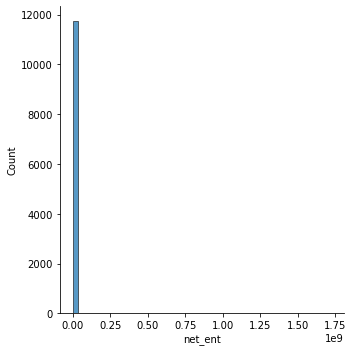

In [259]:
"""
Didn't have great success in trying to figure out Seaborne
"""

plt.figure(figsize = (10, 5))
sns.displot(df.net_ent, bins = 50)
plt.show()

[10281, 7730, 6460, 5591, 4896, 4377, 3908, 3498, 3184, 2911, 2649, 2424, 2216, 2032, 1868, 1701, 1555, 1455, 1359, 1269, 1207, 1142, 1074, 1011, 937, 884, 816, 759, 698, 644, 595, 549, 507, 470, 449, 432, 416, 395, 374, 353, 343, 324, 313, 297, 281, 266, 252, 237, 226, 220, 214, 209, 205, 199, 193, 187, 183, 182, 177, 173, 168, 166, 164, 159, 156, 151, 143, 140, 138, 138, 137, 134, 134, 133, 133, 133, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129,

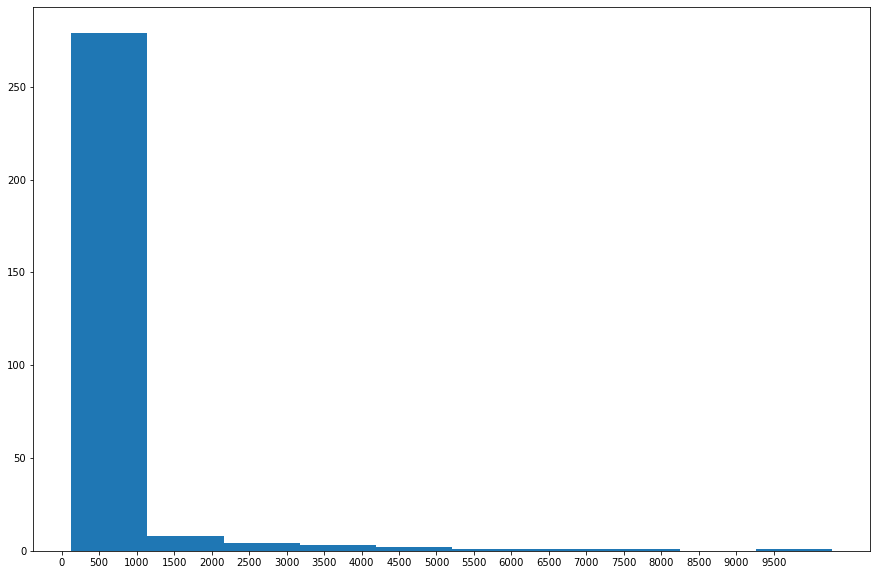

129

In [261]:
"""
Decided to generate my  own cumlative distribution data with parameters I can set.
I then plot with matplot lib
"""
cum_count = []
for i in range(0, 3000, 10):
    cum_count.append(df[df.net_ent > i].count()[0])

print(cum_count)
# plt.figure(figsize = (20, 25), dpi = 60)
# sns.displot(cum_count, bins = 10)
# plt.show()

f, axs = plt.subplots(1,1, figsize = (15, 10))
plt.xticks(range(0, 10000, 500))
axs.hist(cum_count, bins = 10)
plt.show()

df[df.net_ent > 2000].count()[0]

In [263]:
"""
Based on the above analysis, it seems reasonable to assume any data for net entries greater than 
1500 in a four hour time interval at a unique CA/UNIT/SCP turnstile is anomalous and should be dropped
"""

df.drop(df[df.net_ent > 1500].index, inplace = True)


[10151, 7600, 6330, 5461, 4766, 4247, 3778, 3368, 3054, 2781, 2519, 2294, 2086, 1902, 1738, 1571, 1425, 1325, 1229, 1139, 1077, 1012, 944, 881, 807, 754, 686, 629, 568, 514, 465, 419, 377, 340, 319, 302, 286, 265, 244, 223, 213, 194, 183, 167, 151, 136, 122, 107, 96, 90, 84, 79, 75, 69, 63, 57, 53, 52, 47, 43, 38, 36, 34, 29, 26, 21, 13, 10, 8, 8, 7, 4, 4, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

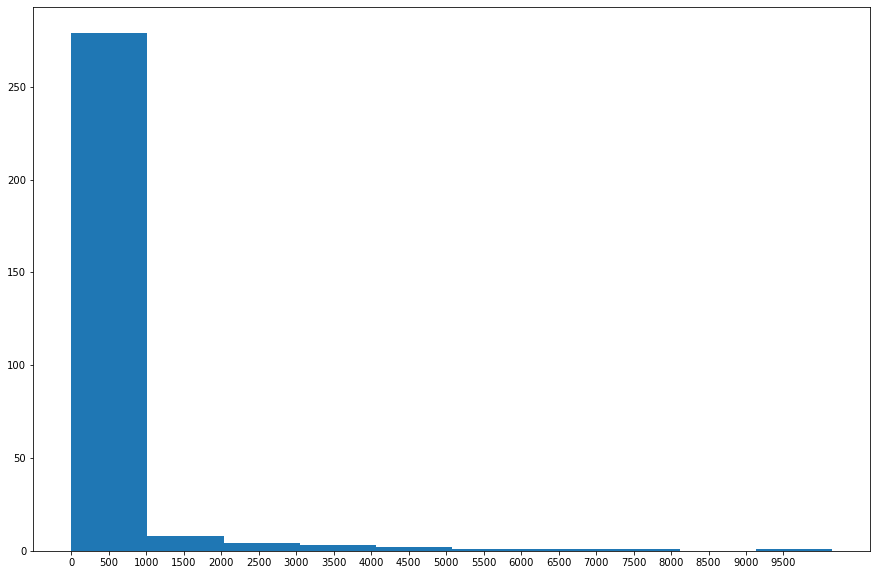

4

In [264]:
"""
Just a check to see what the distribution looks like after I drop rows with greater than 1500 net entries
"""

cum_count = []
for i in range(0, 3000, 10):
    cum_count.append(df[df.net_ent > i].count()[0])

print(cum_count)
# plt.figure(figsize = (20, 25), dpi = 60)
# sns.displot(cum_count, bins = 10)
# plt.show()

f, axs = plt.subplots(1,1, figsize = (15, 10))
plt.xticks(range(0, 10000, 500))
axs.hist(cum_count, bins = 10)
plt.show()

df[df.net_ent > 720].count()[0]

[10530, 7964, 6839, 6114, 5506, 4982, 4574, 4220, 3880, 3548, 3259, 2987, 2776, 2611, 2444, 2292, 2162, 2037, 1913, 1790, 1682, 1577, 1481, 1397, 1305, 1219, 1128, 1045, 964, 886, 817, 749, 698, 648, 597, 545, 498, 467, 423, 388, 362, 343, 312, 283, 267, 249, 227, 202, 181, 165, 150, 133, 110, 102, 100, 90, 86, 83, 78, 69, 65, 63, 58, 55, 52, 46, 42, 39, 35, 31, 28, 26, 21, 19, 18, 15, 15, 14, 13, 12, 10, 10, 9, 9, 8, 6, 6, 6, 5, 5, 5, 5, 5, 4, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

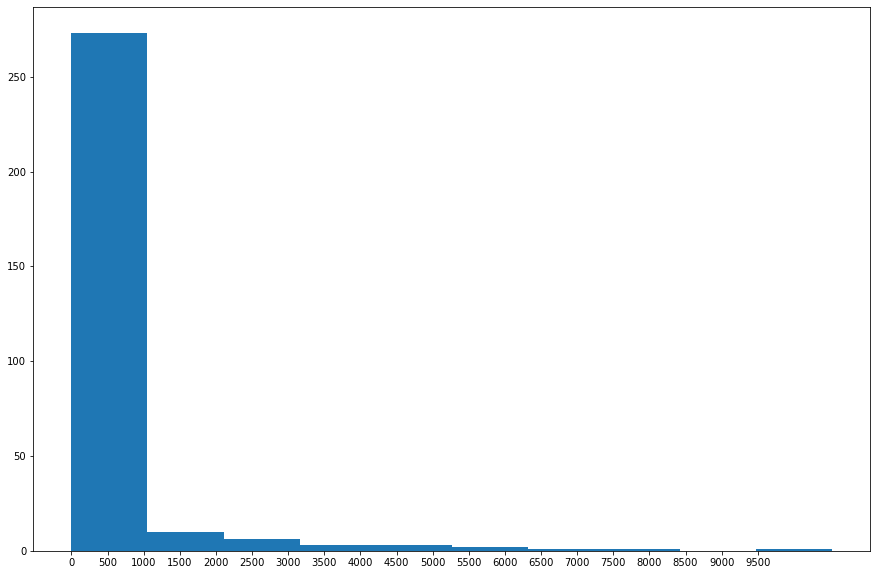

5

In [265]:
"""
Net_exit anomalies have been addressed by droping the net_entries anomalies.
So no further adjustment necessary
"""

cum_count = []
for i in range(0, 3000, 10):
    cum_count.append(df[df.net_ex > i].count()[0])

print(cum_count)

f, axs = plt.subplots(1,1, figsize = (15, 10))
plt.xticks(range(0, 10000, 500))
axs.hist(cum_count, bins = 10)
plt.show()

df[df.net_ex > 900].count()[0]

In [266]:
"""
Now I'm checking for days when then there were 0 entries.
By examining the head and tail of the data, it appears all 0 entires are associated with
the JNQRZ6W line and corresponding portion of the canal st. station complex. It's reasonable to assume
that these 0 entries are due to a station or line closure. So these data points should be dropped
"""
print(df[df.ENTRIES == 0].head(10))
print(df[df.ENTRIES == 0].tail(10))
df.drop(df[df.ENTRIES == 0].index, inplace = True)


       CA  UNIT       SCP   STATION LINENAME        DATE      TIME     DESC  \
836  A046  R463  00-05-03  CANAL ST  JNQRZ6W  10/23/2021  05:00:00  REGULAR   
837  A046  R463  00-05-03  CANAL ST  JNQRZ6W  10/23/2021  09:00:00  REGULAR   
838  A046  R463  00-05-03  CANAL ST  JNQRZ6W  10/23/2021  13:00:00  REGULAR   
839  A046  R463  00-05-03  CANAL ST  JNQRZ6W  10/23/2021  17:00:00  REGULAR   
840  A046  R463  00-05-03  CANAL ST  JNQRZ6W  10/23/2021  21:00:00  REGULAR   
841  A046  R463  00-05-03  CANAL ST  JNQRZ6W  10/24/2021  01:00:00  REGULAR   
842  A046  R463  00-05-03  CANAL ST  JNQRZ6W  10/24/2021  05:00:00  REGULAR   
843  A046  R463  00-05-03  CANAL ST  JNQRZ6W  10/24/2021  09:00:00  REGULAR   
844  A046  R463  00-05-03  CANAL ST  JNQRZ6W  10/24/2021  13:00:00  REGULAR   
845  A046  R463  00-05-03  CANAL ST  JNQRZ6W  10/24/2021  17:00:00  REGULAR   

     ENTRIES  EXITS  prev_ent  prev_ex  net_ent  net_ex  
836        0    583       0.0    583.0      0.0     0.0  
837        0  

In [267]:
"""
Performing the same analysis as above for days with 0 exits.
It again appears all 0 exits are associated with the JNQRZ6W line and corresponding portion of 
the canal st. station complex and on the same days as 0 entries thus reinforcing the hypothesis
that there was some sort line/station closure. So these data points should be dropped as well
"""
print(df[df.EXITS == 0].head(10))
print(df[df.EXITS == 0].tail(10))
df.drop(df[df.EXITS == 0].index, inplace = True)


       CA  UNIT       SCP   STATION LINENAME        DATE      TIME     DESC  \
715  A046  R463  00-05-00  CANAL ST  JNQRZ6W  10/23/2021  05:00:00  REGULAR   
716  A046  R463  00-05-00  CANAL ST  JNQRZ6W  10/23/2021  09:00:00  REGULAR   
717  A046  R463  00-05-00  CANAL ST  JNQRZ6W  10/23/2021  13:00:00  REGULAR   
718  A046  R463  00-05-00  CANAL ST  JNQRZ6W  10/23/2021  17:00:00  REGULAR   
719  A046  R463  00-05-00  CANAL ST  JNQRZ6W  10/23/2021  21:00:00  REGULAR   
720  A046  R463  00-05-00  CANAL ST  JNQRZ6W  10/24/2021  01:00:00  REGULAR   
721  A046  R463  00-05-00  CANAL ST  JNQRZ6W  10/24/2021  05:00:00  REGULAR   
722  A046  R463  00-05-00  CANAL ST  JNQRZ6W  10/24/2021  09:00:00  REGULAR   
723  A046  R463  00-05-00  CANAL ST  JNQRZ6W  10/24/2021  13:00:00  REGULAR   
724  A046  R463  00-05-00  CANAL ST  JNQRZ6W  10/24/2021  17:00:00  REGULAR   

     ENTRIES  EXITS  prev_ent  prev_ex  net_ent  net_ex  
715     4428      0    4428.0      0.0      0.0     0.0  
716     4428  

In [268]:
"""
Analyzing time interval consistency by line name. This is good news since there are no anomalous 
time intervals within each line.  The time intervals for the ACE lines are slightly different than the 
others, but for the purposes of my study, this does not present an issue
"""

time_set_ACE = set(df[df.LINENAME == 'ACE'].TIME)
time_set_J = set(df[df.LINENAME == 'JNQRZ6W'].TIME)
time_set_1 = set(df[df.LINENAME == 'JNQRZ6W'].TIME)

print(time_set_ACE)
print(time_set_J)
print(time_set_1)

{'16:00:00', '00:00:00', '04:00:00', '08:00:00', '20:00:00', '12:00:00'}
{'09:00:00', '13:00:00', '17:00:00', '21:00:00', '01:00:00', '05:00:00'}
{'09:00:00', '13:00:00', '17:00:00', '21:00:00', '01:00:00', '05:00:00'}


In [269]:
""" 
Add columns:
> calculate net_entry + net_exit. This is a good proxy for total traffic around the station
> calculate net_entry - net_exit. This is an indication of traffic direction and perhaps a hint at demographics
> date_time for later analyis potentiall against other data such as weather or covid news etc
> day of week for later analysis based on day of week
"""

df['n_ent + n_ex'] = df.net_ent + df.net_ex
df['n_ent - n_ex'] = df.net_ent - df.net_ex
df['date_time'] = pd.to_datetime(df.DATE + " " + df.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")

df['weekday'] = df['date_time'].dt.day_name()

df

,CA,UNIT,SCP,STATION,LINENAME,DATE,TIME,DESC,ENTRIES,EXITS,prev_ent,prev_ex,net_ent,net_ex,n_ent + n_ex,n_ent - n_ex,date_time,weekday
1,A043,R462,00-00-00,CANAL ST,JNQRZ6W,10/23/2021,05:00:00,REGULAR,371824284,456786141,371824281.0,456786135.0,3.0,6.0,9.0,-3.0,2021-10-23 05:00:00,Saturday
2,A043,R462,00-00-00,CANAL ST,JNQRZ6W,10/23/2021,09:00:00,REGULAR,371824286,456786210,371824284.0,456786141.0,2.0,69.0,71.0,-67.0,2021-10-23 09:00:00,Saturday
3,A043,R462,00-00-00,CANAL ST,JNQRZ6W,10/23/2021,13:00:00,REGULAR,371824313,456786548,371824286.0,456786210.0,27.0,338.0,365.0,-311.0,2021-10-23 13:00:00,Saturday
4,A043,R462,00-00-00,CANAL ST,JNQRZ6W,10/23/2021,17:00:00,REGULAR,371824495,456786992,371824313.0,456786548.0,182.0,444.0,626.0,-262.0,2021-10-23 17:00:00,Saturday
5,A043,R462,00-00-00,CANAL ST,JNQRZ6W,10/23/2021,21:00:00,REGULAR,371824729,456787245,371824495.0,456786992.0,234.0,253.0,487.0,-19.0,2021-10-23 21:00:00,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12130,R120,R320,01-00-02,CANAL ST,1,10/01/2021,05:00:00,REGULAR,1483244,8378167,1483243.0,8378162.0,1.0,5.0,6.0,-4.0,2021-10-01 05:00:00,Friday
12131,R120,R320,01-00-02,CANAL ST,1,10/01/2021,09:00:00,REGULAR,1483247,8378314,1483244.0,8378167.0,3.0,147.0,150.0,-144.0,2021-10-01 09:00:00,Friday
12132,R120,R320,01-00-02,CANAL ST,1,10/01/2021,13:00:00,REGULAR,1483256,8378434,1483247.0,8378314.0,9.0,120.0,129.0,-111.0,2021-10-01 13:00:00,Friday
12133,R120,R320,01-00-02,CANAL ST,1,10/01/2021,17:00:00,REGULAR,1483277,8378556,1483256.0,8378434.0,21.0,122.0,143.0,-101.0,2021-10-01 17:00:00,Friday


In [270]:

"""
Based on some of the analysis above, I noticed that unique combinations of turnstile identifyers CA, UNIT,
SCP are associated with a single line name. The code below confirms that this is the case. I loop over the 
dataframe, isolating each line name at this station, then generate a string combination of CA, UNIT,
SCP for each row and store that in a set for that line name. 

I end up with a set, for each line name of unique combinations of CA, UNIT, and SCP. I then check for 
intersections  between these sets which are empty. so this tells me that I can isolate traffic data by line
name and time interval. When I look at a NYC subway map, the line names cleary match up to different enterances
of the Canal st. complex. So his allows me to analyze data based on time intervals as small as 4 hours
by enterance/line. This is a very good start at micro targeting advertising.
"""



stiles_id_ace = set()
stiles_id_j = set()
stiles_id_1 = set()

for row in df.itertuples(index = True):
    if (row.LINENAME == 'ACE'):
        stiles_id_ace.add(getattr(row, "CA") +  getattr(row, "UNIT") + getattr(row, "SCP") )
print(stiles_id_ace)
print('-'*30 + '\n')

for row in df.itertuples(index = True):
    if (row.LINENAME == 'JNQRZ6W'):
        stiles_id_j.add(getattr(row, "CA") +  getattr(row, "UNIT") + getattr(row, "SCP") )
print(stiles_id_j)
print('-'*30 + '\n')

for row in df.itertuples(index = True):
    if (row.LINENAME == '1'):
        stiles_id_1.add(getattr(row, "CA") +  getattr(row, "UNIT") + getattr(row, "SCP") )
print(stiles_id_1)
print('-'*30 + '\n')


print(stiles_id_ace.intersection(stiles_id_j))
print(stiles_id_ace.intersection(stiles_id_1))
print(stiles_id_j.intersection(stiles_id_1))


{'N089R13900-04-01', 'N089R13900-00-00', 'N090R13901-00-01', 'N090R13901-05-00', 'N089R13900-06-01', 'N089R13900-03-00', 'N089R13900-04-02', 'N089R13900-06-02', 'N089R13900-06-00', 'N089R13900-03-01', 'N090R13901-00-02', 'N090R13901-06-00', 'N089R13900-03-02', 'N089R13900-00-01', 'N090R13901-03-00', 'N089R13900-04-00', 'N090R13901-00-00', 'N090R13901-06-01', 'N089R13900-00-02'}
------------------------------

{'A043R46200-03-03', 'A043R46200-06-00', 'A046R46300-06-07', 'A046R46300-06-01', 'A043R46200-06-01', 'A046R46300-00-00', 'A043R46200-00-02', 'A046R46300-06-06', 'A046R46300-03-01', 'A043R46200-03-00', 'A043R46200-03-02', 'A046R46300-00-03', 'A046R46300-00-02', 'A043R46200-03-04', 'A046R46300-06-03', 'A046R46300-06-08', 'A043R46200-00-01', 'A046R46300-00-01', 'A046R46300-06-02', 'A066R11800-00-02', 'A046R46300-06-00', 'A046R46300-06-05', 'A066R11800-00-01', 'A043R46200-03-01', 'A046R46300-06-04', 'A043R46200-00-00', 'A046R46300-05-02', 'A043R46200-06-02', 'A046R46300-03-00', 'A046R

In [271]:
"""
The data, grouped by line name, is now in a form that will facilitate at least some micro targerted advertising.
"""


df.groupby(['LINENAME', 'DATE', 'TIME']).head(130)

,CA,UNIT,SCP,STATION,LINENAME,DATE,TIME,DESC,ENTRIES,EXITS,prev_ent,prev_ex,net_ent,net_ex,n_ent + n_ex,n_ent - n_ex,date_time,weekday
1,A043,R462,00-00-00,CANAL ST,JNQRZ6W,10/23/2021,05:00:00,REGULAR,371824284,456786141,371824281.0,456786135.0,3.0,6.0,9.0,-3.0,2021-10-23 05:00:00,Saturday
2,A043,R462,00-00-00,CANAL ST,JNQRZ6W,10/23/2021,09:00:00,REGULAR,371824286,456786210,371824284.0,456786141.0,2.0,69.0,71.0,-67.0,2021-10-23 09:00:00,Saturday
3,A043,R462,00-00-00,CANAL ST,JNQRZ6W,10/23/2021,13:00:00,REGULAR,371824313,456786548,371824286.0,456786210.0,27.0,338.0,365.0,-311.0,2021-10-23 13:00:00,Saturday
4,A043,R462,00-00-00,CANAL ST,JNQRZ6W,10/23/2021,17:00:00,REGULAR,371824495,456786992,371824313.0,456786548.0,182.0,444.0,626.0,-262.0,2021-10-23 17:00:00,Saturday
5,A043,R462,00-00-00,CANAL ST,JNQRZ6W,10/23/2021,21:00:00,REGULAR,371824729,456787245,371824495.0,456786992.0,234.0,253.0,487.0,-19.0,2021-10-23 21:00:00,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12130,R120,R320,01-00-02,CANAL ST,1,10/01/2021,05:00:00,REGULAR,1483244,8378167,1483243.0,8378162.0,1.0,5.0,6.0,-4.0,2021-10-01 05:00:00,Friday
12131,R120,R320,01-00-02,CANAL ST,1,10/01/2021,09:00:00,REGULAR,1483247,8378314,1483244.0,8378167.0,3.0,147.0,150.0,-144.0,2021-10-01 09:00:00,Friday
12132,R120,R320,01-00-02,CANAL ST,1,10/01/2021,13:00:00,REGULAR,1483256,8378434,1483247.0,8378314.0,9.0,120.0,129.0,-111.0,2021-10-01 13:00:00,Friday
12133,R120,R320,01-00-02,CANAL ST,1,10/01/2021,17:00:00,REGULAR,1483277,8378556,1483256.0,8378434.0,21.0,122.0,143.0,-101.0,2021-10-01 17:00:00,Friday
